In [2]:
%matplotlib inline

import pandas
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sklearn
matplotlib.style.use('ggplot')

## Load and plot sample data

In [3]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

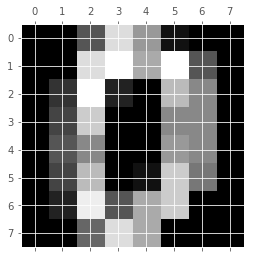

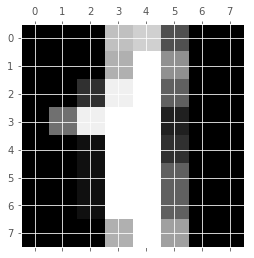

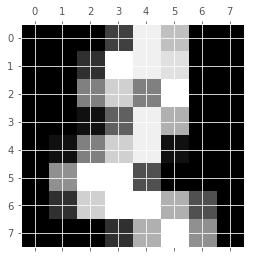

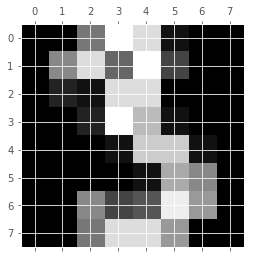

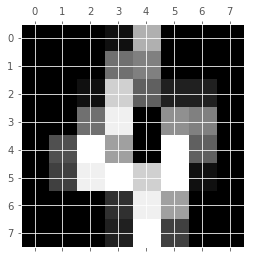

In [10]:
for i in range(5):
    plt.gray() 
    plt.matshow(digits.images[i]) 
    plt.show() 

## Two-class train and test split
For each of the two classes I chose (7 and 8), read out the indices of the relevant class, pick 15 entries to serve a test set for that class, and use the rest as the training set. Then combine the two into training and test sets.

Set seed to make sure it's repeatable, and display the shapes as a sanity check.

In [69]:
np.random.seed(33)

data_indices_7 = np.where(digits.target == 7)[0]
test_indices_7 = np.random.choice(data_indices_7, 15)
train_indices_7 = np.setdiff1d(data_indices_7, test_indices_7)

data_indices_8 = np.where(digits.target == 8)[0]
test_indices_8 = np.random.choice(data_indices_8, 15)
train_indices_8 = np.setdiff1d(data_indices_8, test_indices_8)

test_indices = np.concatenate([test_indices_7, test_indices_8])
train_indices = np.concatenate([train_indices_7, train_indices_8])
test_indices.shape, train_indices.shape

((30,), (324,))

In [70]:
train_set_x = digits.data[train_indices]
train_set_y = digits.target[train_indices]

train_set_x.shape, train_set_y.shape

((324, 64), (324,))

## Cross-validate choice of K
5-fold cross validation for the choice of $k$, keeping all other KNN parameters to their default (tree size, distance metric, and so on)

In [71]:
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.model_selection import cross_val_score

In [72]:
# cross_valiate over values of K
np.random.seed(33)
for k in range(1, 10, 2):
    knn = KNN(n_neighbors=k)
    cv = cross_val_score(knn, train_set_x, train_set_y, cv=5)
    print(k, np.mean(cv), cv)


1 0.996923076923 [ 1.          1.          1.          0.98461538  1.        ]
3 1.0 [ 1.  1.  1.  1.  1.]
5 0.996875 [ 1.        1.        1.        1.        0.984375]
7 0.996875 [ 1.        1.        1.        1.        0.984375]
9 0.996875 [ 1.        1.        1.        1.        0.984375]


## Test k=3 on test set
Create a new model with the optimal choice of $k=3$, fit the model on the entire training set, and test it on the *break glass to use* test set

In [73]:
test_set_x = digits.data[test_indices]
test_set_y = digits.target[test_indices]

optimal_k = 3
knn = KNN(optimal_k)
knn.fit(train_set_x, train_set_y)
knn.score(test_set_x, test_set_y)

1.0

## Running the same routine on all ten classes
Using a test set of 150 random items, unbalanced from the data (or rather, balanced on expectation, not by drawing 15 entries from each class)

In [74]:
np.random.seed(33)
all_indices = np.array(range(len(digits.target)))
all_test_indices = np.random.choice(indices, 150)
all_train_indices = np.setdiff1d(indices, test_indices)

train_x = digits.data[all_train_indices]
train_y = digits.target[all_train_indices]

In [76]:
np.random.seed(33)
for k in range(1, 10, 2):
    knn = KNN(n_neighbors=k)
    cv = cross_val_score(knn, train_x, train_y, cv=5)
    print(k, np.mean(cv), cv)

1 0.96328531537 [ 0.96089385  0.94662921  0.96600567  0.98575499  0.95714286]
3 0.963874279832 [ 0.95530726  0.9494382   0.96600567  0.98290598  0.96571429]
5 0.961057073037 [ 0.94692737  0.9494382   0.96600567  0.98005698  0.96285714]
7 0.957668320202 [ 0.93575419  0.95224719  0.96600567  0.98290598  0.95142857]
9 0.957109489339 [ 0.9301676   0.95224719  0.97450425  0.98005698  0.94857143]


In [77]:
test_x = digits.data[all_test_indices]
test_y = digits.target[all_test_indices]

optimal_k = 3
knn = KNN(optimal_k)
knn.fit(train_x, train_y)
knn.score(test_x, test_y)

0.99333333333333329

The results are surprisingly good on the entire dataset, so let's try real MNIST. 

## Real MNIST
Rather than 8x8, the entries here are 28x28, and the data set is huge, to the extent it's prohibitice to use entire training set. I sampled $10^4$ random entries to use as my training set (again, balanced on expectation only, not by drawing from each class separately), cross-validated my choice of $k$, and after receiving $k=1$, tested on a test set of $10^3$ digits. 

In [80]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')

In [90]:
np.random.seed(33)
TRAINING_SET_SIZE = 10 ** 4

mnist_train_indices = np.random.choice(range(mnist.data.shape[0]), TRAINING_SET_SIZE)
mnist_train_x = mnist.data[mnist_train_indices]
mnist_train_y = mnist.target[mnist_train_indices]
mnist_train_x.shape, mnist_train_y.shape

((10000, 784), (10000,))

In [91]:
np.random.seed(33)
for k in range(1, 10, 2):
    knn = KNN(n_neighbors=k)
    cv = cross_val_score(knn, mnist_train_x, mnist_train_y, cv=5)
    print(k, np.mean(cv), cv)

1 0.95330122418 [ 0.95259481  0.95257114  0.952       0.95545546  0.95388471]
3 0.949900011118 [ 0.9496008   0.94757863  0.9535      0.95095095  0.94786967]
5 0.945896949422 [ 0.9496008   0.94358462  0.9475      0.94844845  0.94035088]
7 0.94289829455 [ 0.9491018   0.93659511  0.944       0.94494494  0.93984962]
9 0.93929758169 [ 0.94461078  0.9335996   0.9415      0.94294294  0.93383459]


In [93]:
np.random.seed(33)
TEST_SET_SIZE = 10 ** 3

indices_without_train = np.setdiff1d(range(mnist.data.shape[0]), mnist_train_indices)
mnist_test_indices = np.random.choice(indices_without_train, TEST_SET_SIZE)
mnist_test_x = mnist.data[mnist_test_indices]
mnist_test_y = mnist.target[mnist_test_indices]

optimal_k = 1
knn = KNN(optimal_k)
knn.fit(mnist_train_x, mnist_train_y)
knn.score(mnist_test_x, mnist_test_y)

0.94099999999999995

The results are astoundingly good again, with an accuracy of 94% on the test set. 